
# G2Net Playground TPU



This notebook has been created to serve as a guided tour to training G2Net models by using Colab TPU. It **MAKES USE** of the code in project-like tree uploaded to my GitHub as well, a code that rocketed the team (ROC & Roll) to top 8% and a bronze medal in its first competition. With all that said, let's ROC it! (Hope you get the joke)

## 1. Introduction

### 1.1 Problem Description

Not only a network of Gravitational Waves, Geophysics and Machine Learning experts, G2Net was also released as a Kaggle competition. I'm pretty sure that you have heard about the discovery of Gravitational Waves (GW), signals from colliding binary black holes, back in 2015. If not, you can refresh your memory with [The Sound of Two Black Holes Colliding](https://www.youtube.com/watch?v=QyDcTbR-kEA). 

The aim of this competition is to detect GW signals from the mergers of binary black holes. Specifically, the participant was expected to build a model to analyse synthetic GW time-series data from a network of Earth-based detectors (LIGO Hanford, LIGO Livingston and Virgo). The [Data](https://www.kaggle.com/c/g2net-gravitational-wave-detection/data) was simulated with a sampling rate of 2048 Hz. Each of the time-series originated by the corresponding detector comprises a channel (three in total).

In the context of this notebook, data has been already standardised (with training set mean and standard deviation), transposed (to ease channels last format) and saved to TensorFlow Records format. Such data can be found in my Kaggle profile, [Training Dataset](https://www.kaggle.com/salbeal94/g2net-float32-train) and [Test Dataset](https://www.kaggle.com/salbeal94/g2net-float32-test). Since it is a classification task, the output is the black hole merger occurence probability. As per the evaluation/validation metric, it is the AUC score.

### 1.2 Implemented Model

After many iterations, the model used for the competition ended up being a 2D Convolutional Neural Network (CNN) preceded by a series of time-series processing techniques. Even the preprocessing has been here implemented as part of the model to stay loyal to the end-to-end philosophy. Such a model contains a series of building blocks several of them presented as trainable Tensorflow Keras layers. These are described as follows:
- **Tukey Window (trainable/non-trainable)**: Introduces a tappering effect that forces the signal amplitude to decay until having zero values at the ends. It is applied to avoid artefacts stemming from discontinuities when taking Fourier transforms or similar.

- **Bandpass Filter (trainable/non-trainable)**: Applies a filter with the frequency response of a Butterworth filter. The idea is to filter out or attenuate frequencies that have nothing to do with the merger.

- **Constant-Q Transform (trainable/non-trainable)**: Transforms the time-domain signal into the time-frequency domain. In other words, it converts a time-domain signal to a spectrogram. Particularly, the PyTorch CQT1992v2 implementation from [nnAudio](https://github.com/KinWaiCheuk/nnAudio) has been taken as reference. It has been re-implemented in TensorFlow for being one of the most cost-effective solutions offered by the library. As an additional functionality, the layer keeps track of maximum spectrogram magnitudes and normalises its values to a preset range for the sake of stability. The output spectrogram is later resized with bilinear interpolation to adapt it to the downstream CNN recommended input sizes.

- **Channel Permutation (non-trainable)**: Randomly decides whether to apply a stochastic permutation of the channels. The aim is to make the prediction a bit less independent of the detector it comes from, pressumably acting as a regularisation layer.

- **Spectral Masking (non-trainable)**: Randomly decides whether to stochastically mask certain time or frequency bands. Similar to the permutation, the idea is for this layer to act as a regularising operation.

- **Convolutional Neural Network (trainable/non-trainable)**: Used as backbone to extract the relevant features to be ingested by a single fully-connected neuron with sigmoid activation (after flattening). Given its performance-complexity trade-off in the ImageNet dataset, the EfficientNet family from [AutoML](https://github.com/google/automl) was selected as a more than appropriate model for this purpose.

![G2Net Model](https://github.com/salvaba94/G2Net/blob/main/img/Model.png?raw=true "G2Net Model")

## 2. Configuration

### 2.1 Environment Configuration

Before starting with implementation-specific details, let's configure some aspects of the environment: 

- Make sure the Colab environment type is set to TPU going to ```Runtime → Change runtime type → TPU```
- Mount your Google Drive to save any output model after the execution.
- Install any library that might be missing from the defaults.



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow-addons
!pip install adabelief-tf
!git clone https://github.com/salvaba94/G2Net.git g2net
!git clone https://github.com/google/automl.git g2net/src/automl

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
Cloning into 'g2net'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 367 (delta 118), reused 327 (delta 87), pack-reused 0
Receiving objects: 100% (367/367), 15.09 MiB | 38.63 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Cloning into 'g2net/src/automl'...
remote: Enumerating objects: 4011, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 4011 (delta 236), reused 300 (delta 188), pack-reused 3613
Receiving objects: 100% (4011/4011), 25.29 MiB | 31.62 MiB/s, done.
Resolving deltas: 100% (2988/2988), done.


### 2.2 Code Configuration 


Now it is high time to start with the Python specifics. Run the following cell to import the necessary libraries for the code to work.

In [ ]:
import sys
import os
import warnings
import copy
import pandas as pd
import numpy as np
import multiprocessing as mp
import tensorflow as tf
import seaborn as sns
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from adabelief_tf import AdaBeliefOptimizer
from datetime import datetime
from pathlib import Path, os
from functools import partial
from scipy import signal
from scipy import interpolate
from typing import Tuple, Union, Mapping
import matplotlib.pyplot as plt

%matplotlib inline

Set the configuration variables necessary for the code to run. Here is where you should come if you would like to play with the model. Don't worry if some of the variables are not clear enough at this point. Their utility can be derived as these are used all along the code.


In [ ]:
class Config:
### General data #############################################################
    N_SAMPLES, N_DETECT = 4096, 3

### Training #################################################################
    FROM_TFR = False
    MODEL_TRAIN = True
    MODEL_SAVE_NAME = "Model_Ref.h5"
    MODEL_PRELOAD = False
    MODEL_PRELOAD_NAME = "Model_Ref.h5"
    HISTORY_NAME = "history_train.csv"

    MODEL_PATH = Path("models")
    CKPT_PATH = Path("checkpoints")

    SPLIT = 0.98
    SEED_SPLIT = 21
    BATCH_SIZE = 128
    BATCH_SIZE_TEST = 32
    EPOCHS = 1
    LEARNING_RATE = 0.0001
    
### Prediction ################################################################
    MODEL_PREDICT = True
    PREDICTIONS_NAME = "submission.csv"


### Model ####################################################################
    TUKEY_SHAPE = 0.25
    TRAINABLE_TUKEY = False

    DEGREE_FILT = 6
    F_BAND_FILT = (20., 500.)
    TRAINABLE_FILT = True

    SAMPLE_RATE = 2048
    F_BAND_SPEC = (20., 500.)
    HOP_LENGTH = 64
    BINS_PER_OCTAVE = 12
    WINDOW_CQT = "hann"
    TRAINABLE_CQT = False
    
    IMAGE_SIZE = 260

    P_PERM = 0.1

    P_MASK = 0.1
    N_MAX_MASK = 2
    W_MASK = (0, IMAGE_SIZE // 6)
    
    MODEL_ID = "efficientnetv2-b2"
    MODEL_ID_WEIGHTS = MODEL_ID

### Plotting #################################################################
    PLOT_EXAMPLE = True
    PLOT_TEST = False

To make use of TPUs, data ingested by the model should be stored in Google Cloud Storage (GCS) buckets. Fortunately, Kaggle is so integrated with Google that public datasets get uploaded to Google Cloud. To know their bucket addresses one should just run the following in a Kaggle notebook:
```
from kaggle_datasets import KaggleDatasets
MODEL_BUCK = KaggleDatasets().get_gcs_path("automl-efficientnetv2-ckpt")
TEST_PATH = KaggleDatasets().get_gcs_path("g2net-float32-test")
TRAIN_PATH = KaggleDatasets().get_gcs_path("g2net-float32-train")
```

The output addresses should be pasted below as raw strings (check them from time to time as they are periodically changed).

In [ ]:
os.environ["MODEL_BUCK"] = r"gs://kds-b512e196d236dcc25f915f875eadb7bcfda6c3ce473349146c8cc4a4"
os.environ["TEST_BUCK"] = r"gs://kds-7f9c8748243b5c63ecfe7739ca8e1cdf5caa2106040be8c8ee1f603a"
os.environ["TRAIN_BUCK"] = r"gs://kds-3e8541897910bfef73ed5b5f448a5bab5df453506aa6d94488411a24"
MODEL_BUCK = os.environ["MODEL_BUCK"]
TEST_BUCK = os.environ["TEST_BUCK"]
TRAIN_BUCK = os.environ["TRAIN_BUCK"]

Run the next cell to tune the paths and add G2Net source code and AutoML EfficientNet model paths to Python path.

In [ ]:
OV_PATH = Path("/content")
SRC_PATH = str(Path(OV_PATH, "g2net", "src"))
CKT_PATH = MODEL_BUCK + "/" + Config.MODEL_ID_WEIGHTS
TRAIN_PATH = TRAIN_BUCK + "/train"
TEST_PATH = TEST_BUCK + "/test"

AUTOML_PATH = str(Path(SRC_PATH, "automl"))
EFFNETV2_PATH = str(Path(AUTOML_PATH, "efficientnetv2"))

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    sys.path.append(AUTOML_PATH)
    sys.path.append(EFFNETV2_PATH)
    
from utilities import PlottingUtilities, GeneralUtilities
from ingest import TFRDatasetCreator, NPYDatasetCreator, DatasetGeneratorTF
from preprocess import SpectralMask, TimeMask, FreqMask, PermuteChannel
from preprocess import TukeyWinLayer, BandpassLayer, WindowingLayer
from preprocess import CQTLayer 
from train import RocLoss, Acceleration, CosineAnnealingRestarts

from automl.efficientnetv2 import effnetv2_model
from automl.efficientnetv2 import hparams
from automl.efficientnetv2 import effnetv2_configs
from automl.efficientnetv2 import utils

The following cell automatically configures the TensorFlow strategy and device (relevant for TPU) and sets the data type to use.

In [ ]:
# Create strategy and define data types for data and tensorflow models
strategy, device = Acceleration.get_acceleration()
dtype = tf.float32 # Do not modify since TF Records are in tf.float32

Device: grpc://10.104.71.50:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.104.71.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.71.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU Number of replicas: 8


Since each TF Record contains several examples (each with ID, time-domain signals and label if any), one might lose track of the number of examples in training and test sets. Actually, it needs to be known to figure out the number of steps per epoch. Such information is contained in two CSV that need to be locally stored. This is the purpose of the following lines.

In [ ]:
!mkdir -p g2net-float32-train
!mkdir -p g2net-float32-test
!gsutil cp $TRAIN_BUCK/training_labels.csv g2net-float32-train
!gsutil cp $TEST_BUCK/sample_submission.csv g2net-float32-test

Copying gs://kds-3e8541897910bfef73ed5b5f448a5bab5df453506aa6d94488411a24/training_labels.csv...
/ [1 files][  6.9 MiB/  6.9 MiB]                                                
Operation completed over 1 objects/6.9 MiB.                                      
Copying gs://kds-7f9c8748243b5c63ecfe7739ca8e1cdf5caa2106040be8c8ee1f603a/sample_submission.csv...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


## 3. Source Code

### 3.1 Custom Model

The building blocks of the model are already implemented in the cloned G2Net source code. Run the following piece of code to define a function that builds and compiles the model. Pay attention to the fact that the model is compiled in the scope of the function to avoid problems with TPU.

In [ ]:
def build_model(
            input_shape: Tuple[int, int],
            window_shape: float = 0.2,
            trainable_window: bool = False,
            sample_rate: float = 2048., 
            degree_filt: int = 8,
            f_band_filt: Tuple[float, float] = (20., 500.),
            trainable_filt: bool = False,
            hop_length: int = 64,
            f_band_spec: Tuple[float, float] = (20., 500.),
            bins_per_octave: int = 12,
            window_cqt: str = "hann",
            perc_range: float = 0.01, 
            trainable_cqt: bool = False,
            resize_shape: Tuple[int, int] = (128, 128),
            p_perm: float = 0.1,
            p_mask: float = 0.1,
            n_max_mask_t: int = 2,
            w_mask_t: Tuple[int, int] = (12, 25),
            n_max_mask_f: int = 2,
            w_mask_f: Tuple[int, int] = (12, 25),
            dtype: type = tf.float32,
            strategy: str = "GPU",
            effnet_id: str = "efficientnetv2-b0",
            weights: str = "imagenet",
            learning_rate: float = 0.001
        ) -> tf.keras.Model:
        """
        Function to build and compile the model.
        
        Parameters
        ----------
        input_shape : Tuple[int, int], 
            Shape of the input to the model without accounting for batch size.
        window_shape : float, optional
            Shape parameter of the Tukey temporal window. The default is 0.2.
        trainable_window : bool, optional
            Whether the Tukey temporal window should be trained or not. 
            The default is False.
        sample_rate : float, optional
            The sampling rate for the input time series. The default is 2048.
        degree_filt : int, optional
            Degree of the bandpass filter. The default is 8.
        f_band_filt : Tuple[float, float], optional
            The frequency band for the bandpass filter [Hz]. The default 
            is (20, 500).
        trainable_filt : bool, optional
            Whether the bandpass filter should be trained or not. 
            The default is False.
        hop_length : int, optional
            The hop (or stride) size for the CQT layer. The default is 512.
        f_band_spec : Tuple[float, float], optional
            The frequency for the lowest (f_min) and highest (f_max) CQT bins [Hz]. 
            The default is (20, 500).
        bins_per_octave : int, optional
            Number of bins per octave for the CQT layer. The default is 12.
        window_cqt : str, optional
            The windowing function for CQT. The default is "hann".
        perc_range : float, optional
            Extra range to apply to tracked spectrogram output maximum to 
            leave a safe margin for non-seen examples. The default is 0.05.
        trainable_cqt : bool, optional
            Whether the cqt layer should be trained or not. If transfer learning 
            is applied, the recommendation is to freeze this layer during the 
            first epochs and activate its training afterwards. The default is False.
        resize_shape : Tuple[int, int], optional
            Spectrogram resize shape without including batch size and channels. 
            The default is (128, 128).
        p_perm : float, optional
            Probability of performing a channel permutation for regularisation.
            The default is 0.1.
        p_mask : foat, optional
            Probability of performing spectral mask for regularisation. The 
            default is 0.1.
        n_max_mask_t : int, optional
            Maximum number of masks in time dimension. The default is 2.
        w_mask_t : Tuple[int, int], optional
            Minimum and maximum width of masking bands in the time dimension. 
            The default is (12, 25).
        n_max_mask_f : int, optional
            Maximum number of masks in frequency dimension. The default is 2.
        w_mask_f : Tuple[int, int], optional
            Minimum and maximum width of masking bands in the frequency dimension. 
            The default is (12, 25).
        dtype : type, optional
            Data type of the model layer parameters. The default is tf.float32.
        strategy : str, optional
            In use strategy. It is mainly used to switch to layers compatible 
            with XLA when using TPU. The default is "GPU".
            Available options are:
                - "TPU"
                - "GPU"
                - "CPU"
        effnet_id : str, optional
            Id of the efficientnet backend model to use. The default is "efficientnetv2-b2".
            Available options are:
                - "efficientnetv2-s"
                - "efficientnetv2-m"
                - "efficientnetv2-l"
                - "efficientnetv2-xl"
                - "efficientnetv2-b0"
                - "efficientnetv2-b1"
                - "efficientnetv2-b2"
                - "efficientnetv2-b3"
                - "efficientnet-b0"
                - "efficientnet-b1"
                - "efficientnet-b2"
                - "efficientnet-b3"
                - "efficientnet-b4"
                - "efficientnet-b5"
                - "efficientnet-b6"
                - "efficientnet-b7"
                - "efficientnet-b8"
                - "efficientnet-l2"
        weights : str, optional
            Whether to use weights from pre-trained models or not. The default 
            is "imagenet". Available options are:
                - "imagenet"
                - "imagenet21k"
                - "imagenet21k-ft1k"
                - "jft"
        learning_rate : float, optional
            Learning rate for the optimizer. The default is 0.001.
        """

        inp = Input(shape = input_shape, dtype = dtype, name = "input")

        if strategy == "TPU":
            window = WindowingLayer(window = ("tukey", window_shape),
                                    window_len = input_shape[0],
                                    trainable = trainable_window, name = "window")
        else:
            window = TukeyWinLayer(initial_alpha = window_shape, 
                                   trainable = trainable_window, name = "window")

        bandpass = BandpassLayer(sample_rate = sample_rate, degree = degree_filt, 
                                      f_band = f_band_filt, n_samples = input_shape[0], 
                                      trainable = trainable_filt, name = "bandpass")
        
        tpu = True if strategy == "TPU" else False
        cqt = CQTLayer(sample_rate = sample_rate, hop_length = hop_length, 
                       f_band = f_band_spec, bins_per_octave = bins_per_octave,
                       window = window_cqt, trainable = trainable_cqt, 
                       perc_range = perc_range, tpu = tpu, name = "cqt")

        resize = Resizing(resize_shape[0], resize_shape[1], name = "resize")
        permute = PermuteChannel(p = p_perm, name = "permute")
        
        if strategy == "TPU":
            mask_t = TimeMask(p = p_mask, w_mask = w_mask_t, name = "mask_t")
            mask_f = FreqMask(p = p_mask, w_mask = w_mask_f, name = "mask_f")
        else:
            mask = SpectralMask(p = p_mask, n_max_mask_t = n_max_mask_t,
                                w_mask_t = w_mask_t, n_max_mask_f = n_max_mask_f,
                                w_mask_f = w_mask_f, name = "mask")

        flatten = Flatten(name = "flatten")
        dense = Dense(units = 1, activation = "sigmoid", name = "dense")

        effnet_config = copy.deepcopy(hparams.base_config)
        effnet_config.override(effnetv2_configs.get_model_config(effnet_id))
        if strategy == "TPU" and not effnet_config.model.bn_type:
            effnet_config.model.bn_type = "tpu_bn"

        effnet = effnetv2_model.get_model(model_name = effnet_id,
            model_config = effnet_config.model, include_top = False, 
            weights = weights)

        x = inp

        y = window(x)
        y = bandpass(y)
        y = cqt(y)
        y = resize(y)
        y = permute(y)

        if strategy == "TPU":
            for _ in range(n_max_mask_t):
                y = mask_t(y)
            for _ in range(n_max_mask_f):
                y = mask_f(y)
        else:
            y = mask(y)

        y = effnet(y)
        y = flatten(y)
        y = dense(y)
        model = tf.keras.Model(inputs = [x], outputs = [y])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # optimizer = AdaBeliefOptimizer(learning_rate = learning_rate, 
        #                                amsgrad = False, print_change_log = False)
        loss = tf.keras.losses.BinaryCrossentropy()
        metric = tf.keras.metrics.AUC()
        model.compile(optimizer = optimizer, loss = loss, metrics = [metric])
        
        return model

### 3.2 Model Training

At this point, it only remains to prepare the datasets with the classes defined above before proceding with training. Of note is that a small proportion of the training dataset is stripped and used for validation purposes.

In [ ]:
# Prepare original dataframes 
sub_file = OV_PATH.joinpath("g2net-float32-test", "sample_submission.csv")
train_labels_file = OV_PATH.joinpath("g2net-float32-train", "training_labels.csv")

train_df_ori = pd.read_csv(train_labels_file)
test_df_ori = pd.read_csv(sub_file)

train_df = pd.DataFrame([Path(x).stem for x in tf.io.gfile.glob(TRAIN_PATH + "/*.tfrec")], columns = ["id"])
train_df = train_df.sample(frac = 1, random_state = Config.SEED_SPLIT).reset_index(drop = True)
test_df = pd.DataFrame([Path(x).stem for x in tf.io.gfile.glob(TEST_PATH + "/*.tfrec")], columns = ["id"])

n_split = np.int32(train_df.shape[0] * Config.SPLIT)
training_df = train_df.loc[:n_split - 1, :]
validation_df = train_df.loc[n_split:, :]
        
training_gen = DatasetGeneratorTF(training_df, TRAIN_PATH, batch_size = Config.BATCH_SIZE, dtype = dtype)
validation_gen = DatasetGeneratorTF(validation_df, TRAIN_PATH, batch_size = Config.BATCH_SIZE, dtype = dtype)
test_gen = DatasetGeneratorTF(test_df, TEST_PATH, batch_size = Config.BATCH_SIZE_TEST, dtype = dtype)
    
training_ds = training_gen.get_dataset(buffer_size = 2048)
validation_ds = validation_gen.get_dataset(buffer_size = 2048)
test_ds = test_gen.get_dataset(shuffle = False, repeat = False, target = False)

# Estimate number of steps per train, validation and test sets
ns_training = np.int32(train_df_ori.shape[0] * Config.SPLIT)
ns_validation = train_df_ori.shape[0] - ns_training
ns_test = test_df_ori.shape[0]
spe_training = np.int32(np.ceil(ns_training / Config.BATCH_SIZE))
spe_validation = np.int32(np.ceil(ns_validation / Config.BATCH_SIZE))
spe_test = np.int32(np.ceil(ns_test / Config.BATCH_SIZE_TEST))

test_ds_id = test_ds.map(lambda data, identity: tf.strings.unicode_encode(
    identity, "UTF-8"))
test_ds_id = test_ds_id.unbatch()
test_ids = next(iter(test_ds_id.batch(test_df_ori.shape[0]))).numpy().astype("U")
test_ds = test_ds.map(lambda data, identity: data)

Now we are ready to build the model within the strategy scope (TPU), preload model weights from local storage (weights other than those provided by AutoML) and train it.

In [ ]:
# Create model, compile and display summary within the scope of the 
# distribution strategy
tf.keras.backend.clear_session()
with strategy.scope():
    model = build_model(input_shape = (Config.N_SAMPLES, Config.N_DETECT), 
                        window_shape = Config.TUKEY_SHAPE,
                        trainable_window = Config.TRAINABLE_TUKEY, 
                        sample_rate = Config.SAMPLE_RATE,
                        degree_filt = Config.DEGREE_FILT, 
                        f_band_filt = Config.F_BAND_FILT,
                        trainable_filt = Config.TRAINABLE_FILT, 
                        hop_length = Config.HOP_LENGTH,
                        f_band_spec = Config.F_BAND_SPEC, 
                        bins_per_octave = Config.BINS_PER_OCTAVE,
                        window_cqt = Config.WINDOW_CQT, 
                        resize_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE),
                        p_perm = Config.P_PERM, p_mask = Config.P_MASK,
                        n_max_mask_t = Config.N_MAX_MASK, 
                        w_mask_t = Config.W_MASK, 
                        n_max_mask_f = Config.N_MAX_MASK,
                        w_mask_f = Config.W_MASK, 
                        strategy = device, weights = CKT_PATH, 
                        effnet_id = Config.MODEL_ID, 
                        learning_rate = Config.LEARNING_RATE)

model.summary()

/content/g2net/src/preprocess/Spectrogram.py:383: SyntaxWarning: If f_max is given, n_bins will be ignored
  warnings.warn("If f_max is given, n_bins will be ignored", SyntaxWarning)
/content/g2net/src/preprocess/Spectrogram.py:156: SyntaxWarning: Using TPU, changing to compatible version
  SyntaxWarning)


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 4096, 3)]    0                                            
__________________________________________________________________________________________________
window (WindowingLayer)         (None, 4096, 3)      4096        input[0][0]                      
__________________________________________________________________________________________________
bandpass (BandpassLayer)        (None, 4096, 3)      2049        window[0][0]                     
__________________________________________________________________________________________________
cqt (CQTLayer)                  (None, 56, 64, 3)    229378      bandpass[0][0]                   
______________________________________________________________________________________________

In [ ]:
if Config.MODEL_PRELOAD:
    pretrained_model = Config.MODEL_PATH.joinpath(Config.MODEL_PRELOAD_NAME)
    local = tf.train.CheckpointOptions(experimental_io_device = "/job:localhost")
    if tf.io.gfile.isdir(pretrained_model):
        pretrained_model = tf.train.latest_checkpoint(pretrained_model)
    model.load_weights(pretrained_model, options = local)

In [ ]:
# Train model with training and validation sets with checkpoints and control 
# over training validation loss plateaus
if Config.MODEL_TRAIN:
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 1, monitor = "val_loss", cooldown = 0, verbose = 1)
    
    local = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
    check_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = Config.CKPT_PATH.joinpath("ckpt-{epoch:d}"),
            save_weights_only = True,
            monitor = "val_auc",
            mode = "max",
            save_best_only = False,
            options = local)
    
    train_history = model.fit(training_ds, epochs = Config.EPOCHS, batch_size = Config.BATCH_SIZE, 
                              validation_data = validation_ds, steps_per_epoch = spe_training,
                              validation_steps = spe_validation, callbacks = [lr_callback, check_callback])

    #best_model_path = tf.train.latest_checkpoint(Config.CKPT_PATH)
    #model.load_weights(best_model_path, options = local)

    Config.MODEL_PATH.mkdir(parents = True, exist_ok = True)
    model.save_weights(Config.MODEL_PATH.joinpath(Config.MODEL_SAVE_NAME), options = local)

    train_hist_df = pd.DataFrame(train_history.history)
    train_hist_df.to_csv(Config.HISTORY_NAME, index = False)

4288/4288 [==============================] - 714s 134ms/step - loss: 0.4642 - auc: 0.8356 - val_loss: 0.4321 - val_auc: 0.8601


### 3.3 Predicting with the Model

Once you are happy with the model, it is time to make predictions on the test set and explore a bit what is actually doing. First, try to obtain the predictions for the full test dataset and plot the output distribution.

7063/7063 [==============================] - 164s 23ms/step

Test dataset output distribution


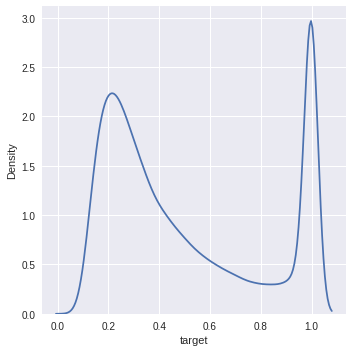

In [ ]:
# Predict on test set and save to submission file
if Config.MODEL_PREDICT:
    preds_test = model.predict(test_ds, batch_size = Config.BATCH_SIZE_TEST, 
                               steps = spe_test, verbose = 1)

    sub_df = pd.DataFrame({
        "id": test_ids,
        "target": preds_test.flatten()
    })

    sub_df = sub_df.sort_values("id").reset_index(drop = True)
        
    sub_df.to_csv(Config.PREDICTIONS_NAME, index = False)

    plt.style.use("seaborn")
    print()
    print("Test dataset output distribution")
    sns.displot(sub_df, x = "target", kind = "kde")

Now let's try to break down the model into its constituent parts and plot the intermediate data for a single example. You might see that, depending on the example, visually identifying a merger chirp becomes difficult or even impossible mainly due other low and high frequency sources of noise (in this case simulated).

In [ ]:
if Config.PLOT_EXAMPLE:

    permute = model.get_layer("permute")
    window = model.get_layer("window")
    bandpass = model.get_layer("bandpass")
    cqt = model.get_layer("cqt")
    resize = model.get_layer("resize")
    permute = model.get_layer("permute")
    mask_t = model.get_layer("mask_t")
    mask_f = model.get_layer("mask_f")
    effnet = model.get_layer(Config.MODEL_ID)
    flatten = model.get_layer("flatten")
    dense = model.get_layer("dense")
        
    if Config.PLOT_TEST:
        for data, _ in test_ds.take(1):
            x_ref = data.numpy()[0, ...][np.newaxis, ...]
    else:
        for data, _ in training_ds.take(1):
            x_ref = data.numpy()[0, ...][np.newaxis, ...]

    x = np.squeeze(x_ref)
    y = x_ref
        
    y = window(y)
    y_win = np.squeeze(y.numpy())
    y = bandpass(y)
    y_band = np.squeeze(y.numpy())
    y = cqt(y, training = False)
    y = resize(y)
    y_spec = np.squeeze(y.numpy())
    y = permute(y, training = True)

    for _ in range(Config.N_MAX_MASK):
        y = mask_t(y, training = True)
    for _ in range(Config.N_MAX_MASK):
        y = mask_f(y, training = True)

    y_masked = np.squeeze(y.numpy())
    y = effnet(y)
    y = flatten(y)
    y = dense(y)
    y_dense = np.squeeze(y.numpy())

Standardised signals


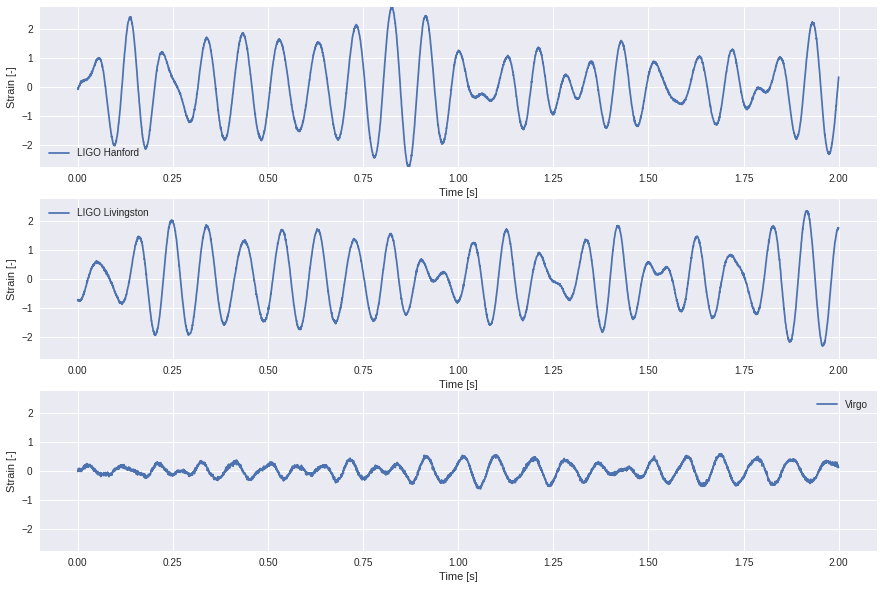

In [ ]:
if Config.PLOT_EXAMPLE:
    print("Standardised signals")
    PlottingUtilities.plot_wave(x)

Tappered signals


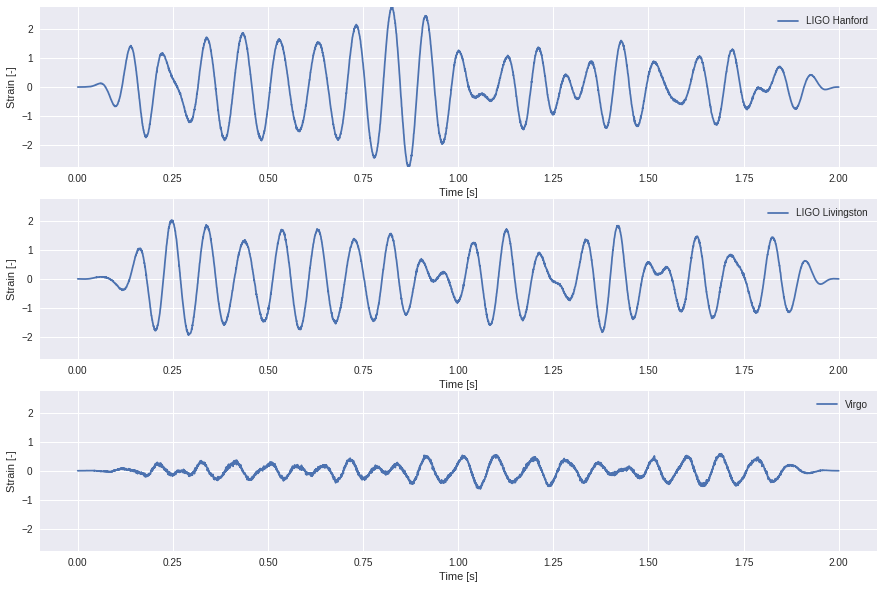

In [ ]:
if Config.PLOT_EXAMPLE:
    print("Tappered signals")
    PlottingUtilities.plot_wave(y_win)

Filtered signals


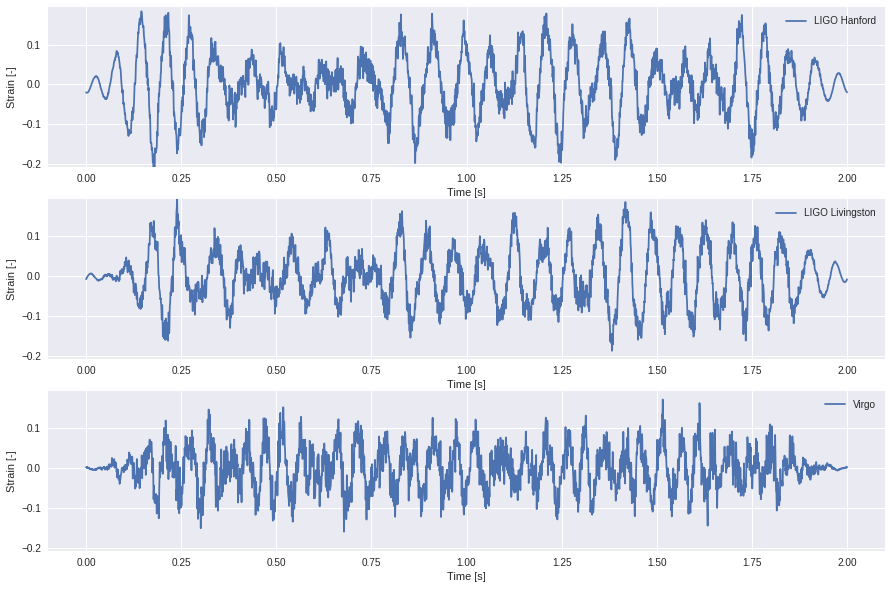

In [ ]:
if Config.PLOT_EXAMPLE:
    print("Filtered signals")
    PlottingUtilities.plot_wave(y_band)

CQT spectrogram


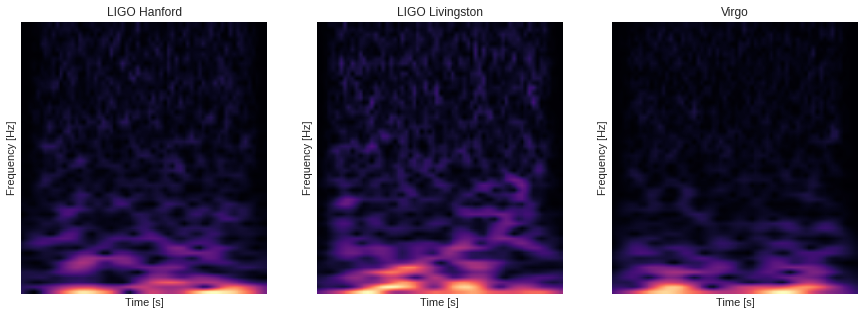

In [ ]:
if Config.PLOT_EXAMPLE:
    print("CQT spectrogram")
    PlottingUtilities.plot_spectrogram(y_spec)

Masked CQT spectrogram


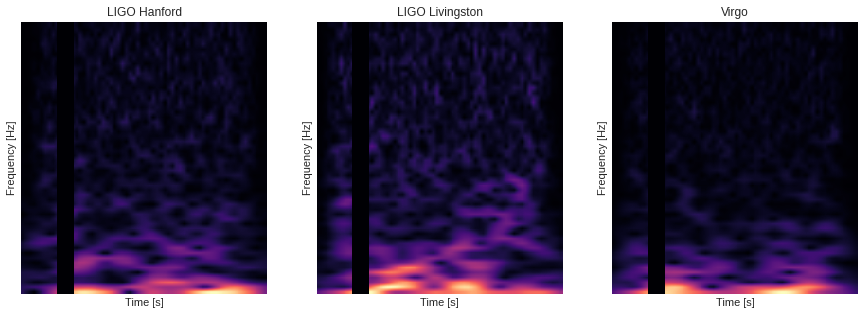

In [ ]:
if Config.PLOT_EXAMPLE:
    print("Masked CQT spectrogram")
    PlottingUtilities.plot_spectrogram(y_masked)

Don't forget to save the results to your Google Drive! Make sure you have enough space as some models are truly heavy.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
os.environ["OUT_NAME"] = "g2net_output"
!echo $OUT_NAME
!mkdir -p $OUT_NAME
!cp -r checkpoints $OUT_NAME
!cp -r models $OUT_NAME
!cp -r *.csv $OUT_NAME
!cp -r $OUT_NAME /content/gdrive/MyDrive/
drive.flush_and_unmount()

Mounted at /content/gdrive
g2net_output



The best G2Net single model was obtained with trainable Tukey window and bandpass layers, a non-trainable CQT, a resize size of 384, an EfficientNet v2 S backbone and training in a Tesla V100 (16GB) GPU with a batch size of 32 (learning rates in the range 0.0003 to 0.00001. The score was boosted with an averaging ensemble of several models with different settings. 

The ROC & Roll team encourages you to play with the code, propose improvements and even introduce new layers that might be of use!